## <b>1 <span style='color:#9146ff'>|</span> Import Libraries and Dataset</b>

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
import evaluate

2024-06-14 19:53:57.018643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 19:53:57.018702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 19:53:57.020397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('../input/real-estate/sampleinput.csv')

# Now df will have columns named 'question' and 'answer'
df.head()

,question,answer
0,I am looking for a house in Vancouver. My budg...,"Okay, here are some property listings matching..."
1,I am interested in the 2nd house. What is the ...,The house is located in the Kitsilano neighbor...
2,"I am looking for a 2-bedroom, 1-bathroom condo...","The price for 2-bedroom, 1-bathroom condos in ..."
3,I am interested in the 4th condo. Can I get mo...,"The building has a gym, pool, and 24-hour conc..."
4,"I am looking for a 3-bedroom, 2-bathroom house...",Here are the property listings for your requir...


## <b>2 <span style='color:#9146ff'>|</span> EDA</b> 

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### 2.1. Basic Exploration:

* Check the data types of columns.
* Get an overview of the dataset's shape (number of rows and columns).
* Check for any missing values.

In [5]:
print("\nData types of columns:")
print(df.dtypes)
print("\nShape of the dataset:")
print(df.shape)
print("\nMissing values:")
print(df.isnull().sum())


Data types of columns:
question    object
answer      object
dtype: object

Shape of the dataset:
(684, 2)

Missing values:
question    0
answer      0
dtype: int64


### 2.2. Text Analysis:

* Analyze the length distribution of questions and answers.
* Check for any unusual characters or patterns in the text.
* Explore the most common words or phrases in questions and answers (word frequency analysis).

In [6]:
# Length distribution of questions and answers
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

### 2.3. Visualization:

* Create visualizations to better understand the data distribution (e.g., histograms, word clouds).
* Plot the distribution of question and answer lengths.
* Visualize word frequency using bar plots or word clouds.

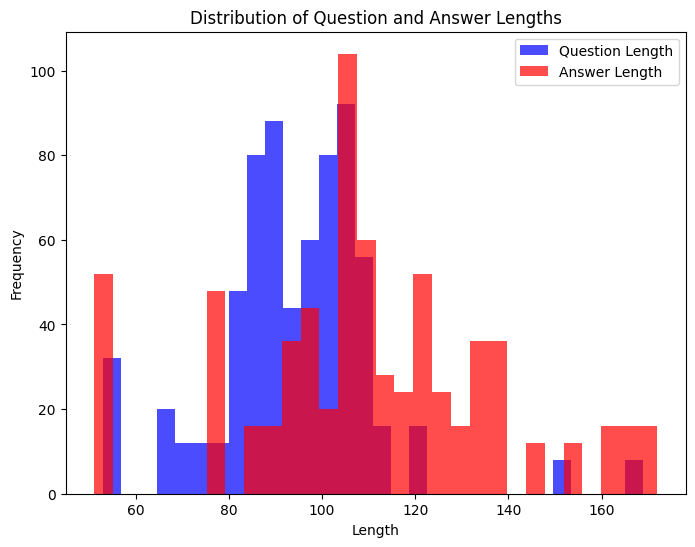

In [7]:
# Visualization
plt.figure(figsize=(8, 6))
plt.hist(df['question_length'], bins=30, alpha=0.7, color='blue', label='Question Length')
plt.hist(df['answer_length'], bins=30, alpha=0.7, color='red', label='Answer Length')
plt.title('Distribution of Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

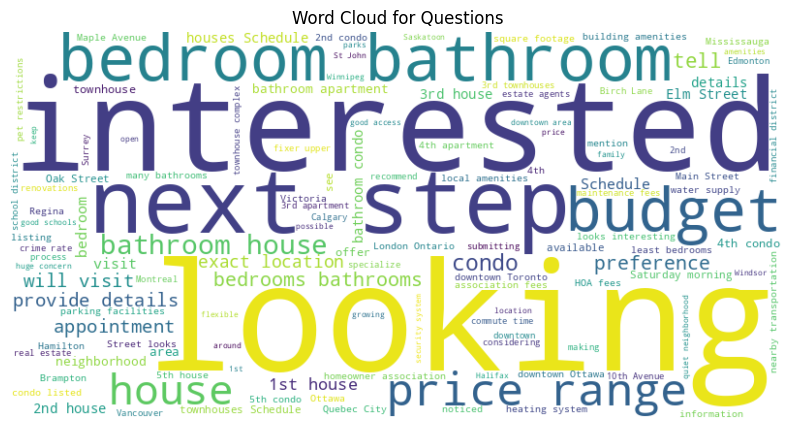

In [8]:
# Word cloud for questions
question_text = ' '.join(df['question'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(question_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')
plt.show()

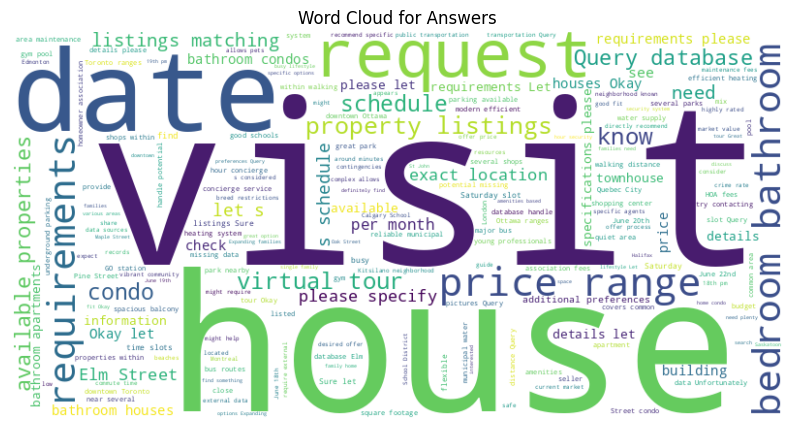

In [9]:
# Word cloud for answers
answer_text = ' '.join(df['answer'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(answer_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Answers')
plt.axis('off')
plt.show()

In [10]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

### 2.4. Topic Modeling:

* Use techniques like Latent Dirichlet Allocation (LDA) to identify underlying topics in the questions and answers.
* Cluster similar questions and answers based on topic distributions.

In [11]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['question'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
# Display the top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:", ", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]))


Topic 0: interested, house, step, details, steps, condo, provide, 4th, 2nd, exact
Topic 1: schedule, visit, appointment, condo, street, houses, like, 789, available, oak
Topic 2: condo, street, tell, elm, fees, visit, schedule, association, homeowner, supply
Topic 3: looking, bathroom, bedroom, house, price, 000, range, budget, bedrooms, bathrooms
Topic 4: house, bedrooms, district, looking, budget, bathrooms, townhouse, 1st, preference, 500


### 2.5. Language Complexity:

* Measure the complexity of language used in questions and answers (e.g., average word length, vocabulary richness).
* Explore readability scores or linguistic features.

In [12]:
df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

# Analyze language complexity
avg_question_word_length = df['question'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()
avg_answer_word_length = df['answer'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()

print("\nAverage word length in questions:", avg_question_word_length)
print("Average word length in answers:", avg_answer_word_length)


Average word length in questions: 4.527886642741448
Average word length in answers: 4.90965789893532


## <b>3 <span style='color:#9146ff'>|</span> Data Preprocessing</b> 

### 3.1. Data Augmentation (UPSampling)

In [14]:
'''# Define the new dialogue data
new_dialogue_data = [
    ["Hi", "Hello"],
    ["How are you?", "I'm good, thanks for asking. How about you?"],
    ["I'm doing well too.", "That's great to hear. What have you been up to lately?"],
    ["Not much, just working and spending time with family.", "That sounds nice. Have you watched any good movies recently?"],
    ["Yeah, I saw a really good one last weekend.", "It was a thriller, right? I heard good things about it."],
    ["Yes, it was.", "Do you want to watch it together sometime?"],
    ["Sure, that sounds like a plan.", "Awesome! Let's plan it for this weekend."],
    ["Sounds good to me.", "Alright then, it's a plan. What time works for you?"],
    ["How about Saturday evening?", "Perfect! Saturday evening it is. I'll book the tickets."],
    ["Great! Looking forward to it.", "Me too. It'll be fun."]
]
new_df = pd.DataFrame(new_dialogue_data, columns=columns)

# Concatenate the new DataFrame with the existing DataFrame
df = pd.concat([df, new_df], ignore_index=True)

# Print the updated DataFrame
df  '''

'# Define the new dialogue data\nnew_dialogue_data = [\n    ["Hi", "Hello"],\n    ["How are you?", "I\'m good, thanks for asking. How about you?"],\n    ["I\'m doing well too.", "That\'s great to hear. What have you been up to lately?"],\n    ["Not much, just working and spending time with family.", "That sounds nice. Have you watched any good movies recently?"],\n    ["Yeah, I saw a really good one last weekend.", "It was a thriller, right? I heard good things about it."],\n    ["Yes, it was.", "Do you want to watch it together sometime?"],\n    ["Sure, that sounds like a plan.", "Awesome! Let\'s plan it for this weekend."],\n    ["Sounds good to me.", "Alright then, it\'s a plan. What time works for you?"],\n    ["How about Saturday evening?", "Perfect! Saturday evening it is. I\'ll book the tickets."],\n    ["Great! Looking forward to it.", "Me too. It\'ll be fun."]\n]\nnew_df = pd.DataFrame(new_dialogue_data, columns=columns)\n\n# Concatenate the new DataFrame with the existing Dat

### 3.2. Preprocessing
* Lowercase
* Tokenization
* Stop words removal
* Lemmization

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
#     tokens = word_tokenize(text)
#     tokens = [word for word in tokens if word.isalnum()]
#     preprocessed_text = ' '.join(tokens)
    
    return text

# Apply preprocessing to question and answer columns
preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

# Print the preprocessed DataFrame
preprocessed_df

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,i am looking for a house in vancouver. my budg...,"okay, here are some property listings matching...",103,122,19,19
1,i am interested in the 2nd house. what is the ...,the house is located in the kitsilano neighbor...,89,146,17,24
2,"i am looking for a 2-bedroom, 1-bathroom condo...","the price for 2-bedroom, 1-bathroom condos in ...",105,132,19,19
3,i am interested in the 4th condo. can i get mo...,"the building has a gym, pool, and 24-hour conc...",109,126,21,23
4,"i am looking for a 3-bedroom, 2-bathroom house...",here are the property listings for your requir...,85,104,14,16
...,...,...,...,...,...,...
679,i am interested in the 3rd apartment. can you ...,the maintenance fees are $350 per month. you c...,109,92,20,17
680,"i am looking for a 5-bedroom, 4-bathroom house...",here are the property listings matching your r...,80,110,14,17
681,i am interested in the 2nd house. what is the ...,the crime rate in this area is low and it’s co...,94,105,20,21
682,i am looking for a townhouse in edmonton with ...,the price range for such townhouses in edmonto...,98,101,19,17


## <b>4 <span style='color:#9146ff'>|</span> Classical ML ChatBot</b> 

In [16]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df['question'], preprocessed_df['answer'], test_size=0.2, random_state=42, shuffle=True)

### 4.1. Model Pipline and training

In [17]:
Pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

Pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [18]:
Pipe.predict(['where are you going'])[0]

'great! we can definitely find something that fits your needs. are you interested in a single-family home, condo, or townhouse?'

### 4.2. Model Evaluation

In [19]:
# Predicting text using the pipeline on the test set
predicted_text = Pipe.predict(X_test)

# Creating a DataFrame to compare the first 10 results
comparison_df = pd.DataFrame({'Real Question ': X_test[:10],'Real Generated Text': y_test[:10], 'Predicted Text': predicted_text[:10]})
comparison_df.head(10)

,Real Question,Real Generated Text,Predicted Text
497,i am looking for a house in vancouver. my budg...,"okay, here are some property listings matching...","okay, here are some property listings matching..."
231,i am looking for a house in calgary with a bud...,here are the available properties for your req...,here are the available properties for your req...
212,i'm interested in a condo with at least 2 bedr...,condos downtown can be a great option for a bu...,condos downtown can be a great option for a bu...
118,i am interested in the 1st house. what is the ...,the house has a reliable municipal water suppl...,the house has a reliable municipal water suppl...
670,"i am looking for a 2-bedroom, 1-bathroom condo...","the price for 2-bedroom, 1-bathroom condos in ...","the price for 2-bedroom, 1-bathroom condos in ..."
539,"i am looking for a 4-bedroom, 3-bathroom house...","the price range for 4-bedroom, 3-bathroom hous...","the price range for 4-bedroom, 3-bathroom hous..."
260,i am interested in the 2nd house. what is the ...,the exact location is 321 oak street. you can ...,the exact location is 321 oak street. you can ...
210,i am interested in the 4th condo. can you prov...,the condo has a 24-hour security system. you c...,the condo has a 24-hour security system. you c...
145,i'm interested in the condo listed at 123 main...,(query database) that condo has 2 bathrooms an...,(query database) that condo has 2 bathrooms an...
582,i am interested in the 4th house. what is the ...,the exact location is 456 maple street. you ca...,the exact location is 456 maple street. you ca...


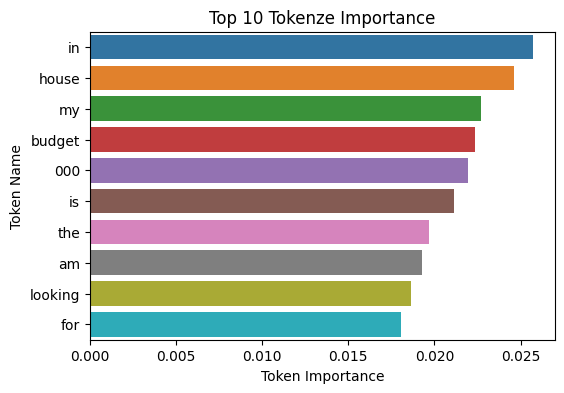

In [20]:
import seaborn as sns

# Visualize Feature Importance
if isinstance(Pipe.named_steps['classifier'], RandomForestClassifier):
    feature_importances = Pipe.named_steps['classifier'].feature_importances_
    feature_names = Pipe.named_steps['tfidf'].get_feature_names_out()

    # Sort feature importances
    sorted_indices = feature_importances.argsort()[::-1]
    top_feature_importances = feature_importances[sorted_indices][:10]
    top_feature_names = np.array(feature_names)[sorted_indices][:10]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=top_feature_importances, y=top_feature_names)
    plt.xlabel('Token Importance')
    plt.ylabel('Token Name')
    plt.title('Top 10 Tokenze Importance')
    plt.show()


### 4.3. Chat with you ChatBot :D

In [ ]:
# Uncomment this cell to try it :) 


# Function to get response from chatbot
def get_response(question):
    response = Pipe.predict([question])[0]
    return response

# Function to interact with the user
def chat():
    while True:
        question = input("You: ")
        if question.lower() == 'quit':
            print("Chatbot: Goodbye!")
            break
        response = get_response(question)
        print("Chatbot:", response)

# Start the chat
chat()

## <b>5 <span style='color:#9146ff'>|</span> Encoder - Decoder Model with Attention and LSTMs Chatbot from scratch </b> 

In [ ]:
# !pip install tensorflow -q

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate

### 5.1. Seq2Seq Text Preprocessing

In [23]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import unicodedata


nltk.download('punkt')

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    text =  "<sos> " +  text + "<eos>"
    return text

# Apply preprocessing to question and answer columns
preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

# Print the preprocessed DataFrame
preprocessed_df

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,<sos> i am looking for a house in vancouver m...,<sos> okay here are some property listings ma...,103,122,19,19
1,<sos> i am interested in the house what is th...,<sos> the house is located in the kitsilano ne...,89,146,17,24
2,<sos> i am looking for a bedroom bathroom con...,<sos> the price for bedroom bathroom condos i...,105,132,19,19
3,<sos> i am interested in the condo can i get ...,<sos> the building has a gym pool and hour c...,109,126,21,23
4,<sos> i am looking for a bedroom bathroom hou...,<sos> here are the property listings for your ...,85,104,14,16
...,...,...,...,...,...,...
679,<sos> i am interested in the apartment can yo...,<sos> the maintenance fees are per month you...,109,92,20,17
680,<sos> i am looking for a bedroom bathroom hou...,<sos> here are the property listings matching ...,80,110,14,17
681,<sos> i am interested in the house what is th...,<sos> the crime rate in this area is low and i...,94,105,20,21
682,<sos> i am looking for a townhouse in edmonton...,<sos> the price range for such townhouses in e...,98,101,19,17


### 5.2. Tokenizer

In [24]:
# Preprocessing the data
questions = preprocessed_df['question'].values.tolist()
answers = preprocessed_df['answer'].values.tolist()

# Tokenizing the data
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(np.concatenate((questions, answers), axis=0))

vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
question_seqs = tokenizer.texts_to_sequences(questions)
answer_seqs = tokenizer.texts_to_sequences(answers)

# Padding sequences for equal length
# Pad sequences for equal length
max_len_question = max(len(seq) for seq in question_seqs)
max_len_answer = max(len(seq) for seq in answer_seqs)
max_len = max(max_len_question, max_len_answer)
print(max(max_len_question, max_len_answer))
# Pad sequences separately for questions and answers
question_seqs = pad_sequences(question_seqs, maxlen=max_len, padding='post')
answer_seqs = pad_sequences(answer_seqs, maxlen=max_len, padding='post')

34


In [25]:
tokenizer.texts_to_sequences("<sos>")

[[], [47], [], [47], []]

In [26]:
tokenizer.word_index["<sos>"]

2

### 5.3. Model Architecture

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate, Dropout

# Define the model architecture
latent_dim = 256  # Dimensionality of the encoding space

# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len,))
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len-1,))
decoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len-1,))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding(decoder_inputs), initial_state=encoder_states)

# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Add dropout layer for regularization
decoder_concat_input = Dropout(0.1)(decoder_concat_input)

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 5.4. Model Training

In [28]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Print model summary
model.summary()

# Train the model
model.fit([question_seqs, answer_seqs[:, :-1]], answer_seqs[:, 1:],
          batch_size=64,
          epochs=32,
          validation_split=0.2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │     85,248 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 33, 256)   │     85,248 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 34, 256), │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 33, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 33, 256)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33, 512)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 33, 512)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 33, 333)   │    170,829 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,391,949 (5.31 MB)

 Trainable params: 1,391,949 (5.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - loss: 5.1460 - val_loss: 3.1501
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0543 - val_loss: 2.7640
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.7968 - val_loss: 2.6305
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.6387 - val_loss: 2.5120
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 2.5868 - val_loss: 2.3988
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 2.4664 - val_loss: 2.2805
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.2779 - val_loss: 2.1447
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 2.1662 - val_loss: 1.9630
Epoch 9/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 1.9438 - val_loss: 1.7629
Epoch 10/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 1.7716 - val_loss: 1.5840
Epoch 11/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 1.6109 - val_loss: 1.4002
Epoch 12/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 1.4277 - val_loss: 1.2266


### 5.5. Model Prediction Evaluation

In [30]:
# Function to generate a response given a input sentence
def generate_response(input_text):
    # Tokenize the input text
    input_sequence = tokenizer.texts_to_sequences([input_text])
    # Pad the input sequence
    input_sequence = pad_sequences(input_sequence, maxlen=max_len, padding='post')
    
    # Initialize the decoder input sequence with start token
    decoder_input_sequence = np.zeros((1, max_len-1))
    decoder_input_sequence[0, 0] = tokenizer.word_index['<sos>']
    
    # Generate response using the trained model
    for i in range(max_len - 1):
        predictions = model.predict([input_sequence, decoder_input_sequence])
        predicted_id = np.argmax(predictions[0, i, :])
        if predicted_id == tokenizer.word_index['<eos>']:
            break
        decoder_input_sequence[0, i+1] = predicted_id
    
    # Convert output sequence to text
    output_text = ''
    for token_index in decoder_input_sequence[0]:
        if token_index == tokenizer.word_index['<eos>'] or token_index == 0:
            break
        output_text += tokenizer.index_word[token_index] + ' '
    
    return output_text.strip()

# Test the function with input "how are you"
input_text = " i am interested in this apartment what is the maitenance fee"
response = generate_response(input_text)
print("Response:", response[5:])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Response:  the price range for bedroom bathroom apartments in quebec city is from to here are some listings
